Data Preparation

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Load data (replace 'AAPL' with your desired stock ticker)
ticker = input('Enter Stock Name: ')
ticker = ticker.upper() # in case of user input lower case alphabet
start_date = '2019-01-01'
end_date = '2024-10-12'

# Fetch data
data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']]
data = data.rename(columns={"Close": "Price"})
data.head()


Enter Stock Name: kbank.bk


[*********************100%***********************]  1 of 1 completed


Price,Price
Ticker,KBANK.BK
Date,
2019-01-02 00:00:00+00:00,185.0
2019-01-03 00:00:00+00:00,186.0
2019-01-04 00:00:00+00:00,186.0
2019-01-07 00:00:00+00:00,188.0
2019-01-08 00:00:00+00:00,186.5


Feature Engineering


In [26]:
# Adding Moving Averages
data['MA20'] = data['Price'].rolling(window=20).mean()
data['MA50'] = data['Price'].rolling(window=50).mean()

# Drop NaN values
data.dropna(inplace=True)


Train-Test Split

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[('Price', ticker)].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create dataset
time_step = 60  # 60 days
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



Model Building


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Training

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train, epochs=1250, batch_size=32, validation_split=0.1, callbacks=[early_stopping])



Epoch 1/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0947 - val_loss: 0.0053
Epoch 2/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 9.6556e-04
Epoch 3/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 9.5200e-04
Epoch 4/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 7.5990e-04
Epoch 5/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 6/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 8.2184e-04
Epoch 7/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 9.5822e-04
Epoch 8/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 7.3311e-04
Epoch 9/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 7.3345e-04
Epoch 10/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 11/1250
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 8.9000e-04
Epoch 12/1250
29

Prediction

In [30]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Visualization

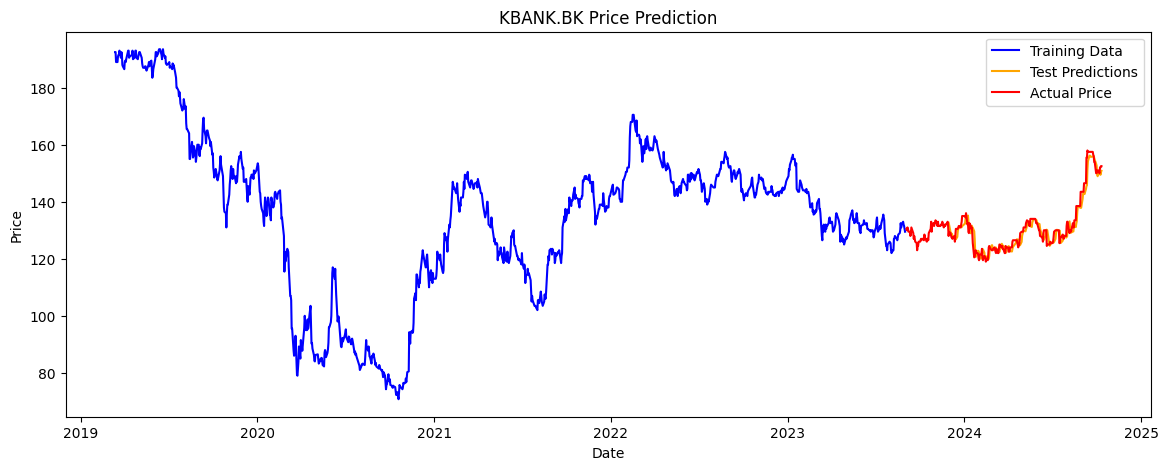

In [31]:
# Plotting
plt.figure(figsize=(14, 5))
plt.plot(data.index[:train_size], data['Price'][:train_size], label='Training Data', color='blue')
plt.plot(data.index[train_size + time_step + 1:], test_predict, label='Test Predictions', color='orange')
plt.plot(data.index[train_size:], data['Price'][train_size:], label='Actual Price', color='red')
plt.title(f'{ticker} Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Future Stock Prediction for 2 Years

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

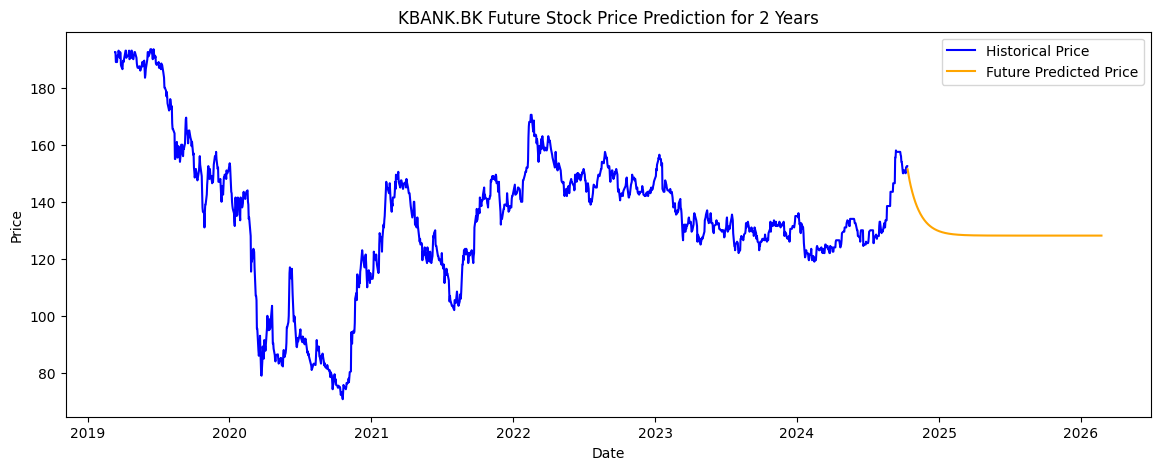

In [32]:
# Number of days to predict into the future (approx. 500 trading days for 2 years)
future_steps = 500

# Get the last part of the training data to seed the prediction (last 'time_step' days)
last_data = scaled_data[-time_step:]

# Reshape last_data to match LSTM input format
last_data = last_data.reshape(1, time_step, 1)

# List to store future predictions
future_predictions = []

# Predict future prices for 500 days
for _ in range(future_steps):
    # Predict the next value
    next_price = model.predict(last_data)

    # Append the predicted value to the future predictions list
    future_predictions.append(next_price[0, 0])

    # Update last_data to include the new prediction and drop the oldest value
    last_data = np.concatenate([last_data[:, 1:, :], next_price.reshape(1, 1, 1)], axis=1)

# Inverse scale the future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a date range for future predictions
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Create a DataFrame for future predictions
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted Price'])

# Plot the future predictions
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Price'], label='Historical Price', color='blue')
plt.plot(future_df.index, future_df['Predicted Price'], label='Future Predicted Price', color='orange')
plt.title(f'{ticker} Future Stock Price Prediction for 2 Years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
